# Linear regression

Problem: Model the relation between the mileage of a car and its price using a linear function. We're given a dataset in the csv format.
First we will graph the data points using a scatter plot.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv

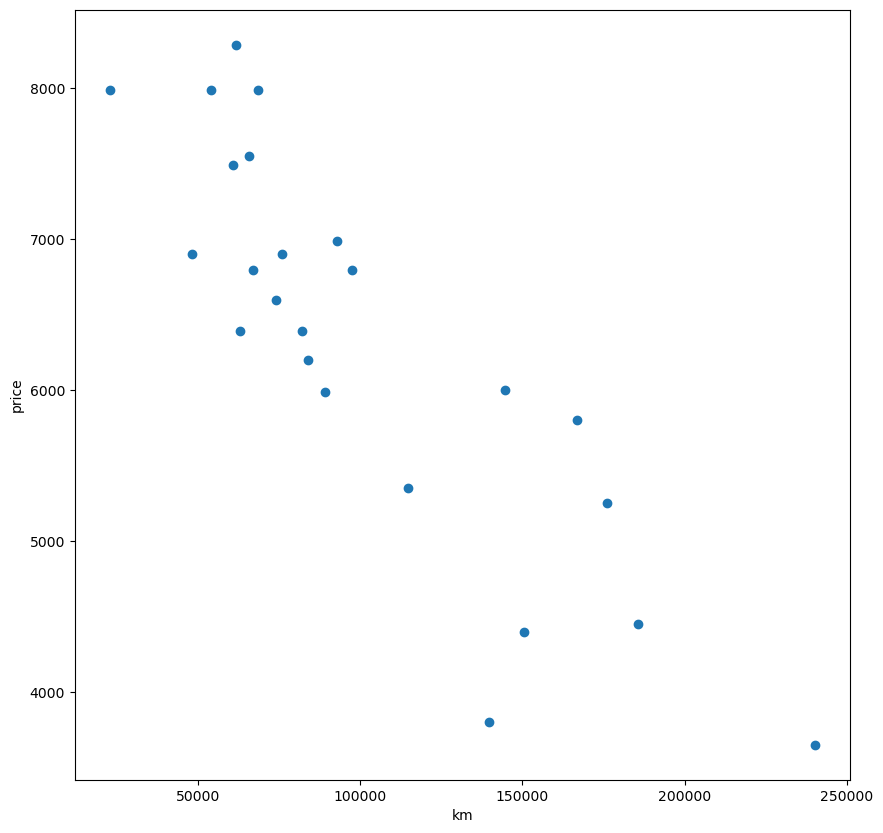

In [3]:
with open('../data.csv') as data_file:
    data_reader = csv.reader(data_file)
    raw_data = list(data_reader)
    # Slice to remove the first row (column names), convert to float and store in a numpy array
    data = np.array([[float(row[0]), float(row[1])] for row in raw_data[1:]])
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel('km')
    plt.ylabel('price')
    plt.scatter(data[:, 0], data[:, 1])

Visualizing the data we can see a negative dependence between the mileage of a car and its price. The more mileage a car has, the cheaper it's going to cost. We also can see that the relation seems linear as no curve or groups seem to manifest in the dataset for instance.

The *linear regression* problem is to fit a set of observations (datapoints) using a *linear function* of the form:
$$f(x) = ax + b$$

The goal is to optimize the slope (or weight) $a$ and the intercept (or bias) $b$ so the linear function minimizes a measure of the error.
In regression, we call these the parameters, and they're named $\beta_n$. The estimator function we're trying to optimize is then:
$$\hat{y} = \hat{\beta_0} + \hat{\beta_1}x$$

Because the relation is negative, we expect to have a negative $\beta_1$. Also we can estimate $\beta_0$ to be somewhere near 400000 because it seems to cross the abscissa around this value.

In [4]:
def linear_model(x, beta0, beta1):
    return beta0 + x * beta1

The error measure we use is the *Mean Error* defined as:
$$
\begin{align}
ME & = \frac{1}{n}\sum_{i=1}^{n}\hat{y_i} - y_i\\
& = \frac{1}{n}\sum_{i=1}^{n}\left(\hat{\beta_0} + \hat{\beta_1} x_i\right) - y_i
\end{align}
$$

This error measures is simply the mean of all *residuals* (the individual errors for each datapoints we get by subtracting the datapoint to our prediction).

Another common error measure is the *Mean Squared Error* where we square the error to only keep positive values and to give more weight to outliers:
$$ MSE= \frac{1}{n}\sum_{i=1}^{n}\left( \hat{y_i} - y_i \right) ^2$$


In [5]:
def mean_error(datapoints, beta0, beta1, model):
    return sum(datapoint[1] - model(datapoint[0], beta0, beta1) for datapoint in datapoints) / len(datapoints)

def mean_squared_error(datapoints, beta0, beta1, model):
    return sum((datapoint[1] - model(datapoint[0], beta0, beta1)) ** 2 for datapoint in datapoints) / len(datapoints)

During the regression, we seek to update $\beta_0$ and $\beta_1$ so the $MSE$ decreases until we find a minima of error.

To this effect, we will leverage a *gradient descent* scheme where at each step, we will calculate the gradient of the slope of the error function to update our parameters in the direction where the gradient decreases.

To do so, we need to calculate the partial derivatives of the $ME$.

First let's calculate the derivative of $\hat{y_i}$ relative to $\beta_0$ and $\beta_1$:
$$\frac{\partial \hat{y_i}}{\partial{\beta_0}} = 1 + 0x_i = 1$$
$$\frac{\partial \hat{y_i}}{\partial{\beta_1}} = 0 + 1x_i  = x_i$$

By defining $u = \hat{y_i} - y_i$ we can express $ME$ as $\frac{1}{n}\sum_{i=1}^{n}u$

We then have:

$$\frac{\partial u}{\partial{\hat{y_i}}} = 1 - 0  = 1$$

By virtue of the constant product rule, we have:

$$\frac{\partial{ME}}{\partial{u}} = \frac{1}{n}\sum_{i=1}^{n}u$$

By virtue of the chain rule, the derivative of $ME$ relative to $\hat{y_i}$ is:
$$\frac{\partial ME}{\partial{\hat{y_i}}} = \frac{\partial{ME}}{\partial{u}} \frac{\partial{u}}{\partial{\hat{y_i}}} = \frac{1}{n}\sum_{i=1}^{n}\hat{y_i} - y_i \times 1 = \frac{1}{n}\sum_{i=1}^{n}\hat{y_i} - y_i$$

Finally we can express the partial derivatives of $ME$ relative to our parameters $\beta_0$ and $\beta_1$:

$$\frac{\partial ME}{\partial \beta_0} = \frac{\partial ME}{\partial \hat{y_i}} \frac{\partial \hat{y_i}}{\partial \beta_0} = \frac{1}{n}\sum_{i=1}^{n}(\beta_0 + \beta_1 x_i) - y_i$$
$$\frac{\partial ME}{\partial \beta_1} = \frac{\partial ME}{\partial \hat{y_i}} \frac{\partial \hat{y_i}}{\partial \beta_1} = \frac{1}{n}\sum_{i=1}^{n}\left((\beta_0 + \beta_1 x_i) - y_i\right) x_i$$

The gradient of $ME$ is then:

$$\nabla ME = \begin{bmatrix}
\frac{1}{n}\sum_{i=1}^{n}(\beta_0 + \beta_1 x_i) - y_i\\
\frac{1}{n}\sum_{i=1}^{n}\left((\beta_0 + \beta_1 x_i) - y_i\right) x_i
\end{bmatrix}$$

Now that we know the gradient of the error function, we can use it to compute the slope of the error function at the point we're at with our parameters $\beta_0$ and $\beta_0$ initialized. This gives us the direction we need to update to minimize the error. If the slope is positive for a parameter, then we need to decrease the parameter and conversely. The higher the absolute value of the slop is, the more we want to change our parameter. When the gradient is 0, we've found the optimal set of parameters.

We can express the update rules for $\beta_0$ and $\beta_1$, with $\alpha $ as the *learning rate*, as follows:

$$ \beta_0 := \beta_0 - \alpha \frac{1}{n}\sum_{i=1}^{n}(\beta_0 + \beta_1 x_i) - y_i $$
$$ \beta_1 := \beta_1 - \alpha \frac{1}{n}\sum_{i=1}^{n}\left((\beta_0 + \beta_1 x_i) - y_i\right) x_i $$

In [6]:
def fit_linear_with_mean_error_gradient_descent(datapoints, beta0, beta1, learning_rate=0.001, iterations=20):
    n = len(datapoints)
    for _ in range(iterations):
        delta_beta0 = sum(linear_model(datapoint[0], beta0, beta1) - datapoint[1] for datapoint in datapoints) / n
        delta_beta1 = sum((linear_model(datapoint[0], beta0, beta1) - datapoint[1]) * datapoint[0] for datapoint in datapoints) / n
        beta0 = beta0 - learning_rate * delta_beta0
        beta1 = beta1 - learning_rate * delta_beta1
    return beta0, beta1

We still need something however. If we tried our linear regression algorithm just yet we would see it fails to fit the dataset. Even worse it overflows !

/tmp/ipykernel_187931/2583938080.py:5: RuntimeWarning: overflow encountered in double_scalars
  delta_beta1 = sum((linear_model(datapoint[0], beta0, beta1) - datapoint[1]) * datapoint[0] for datapoint in datapoints) / n
/tmp/ipykernel_187931/2583938080.py:7: RuntimeWarning: invalid value encountered in double_scalars
  beta1 = beta1 - learning_rate * delta_beta1


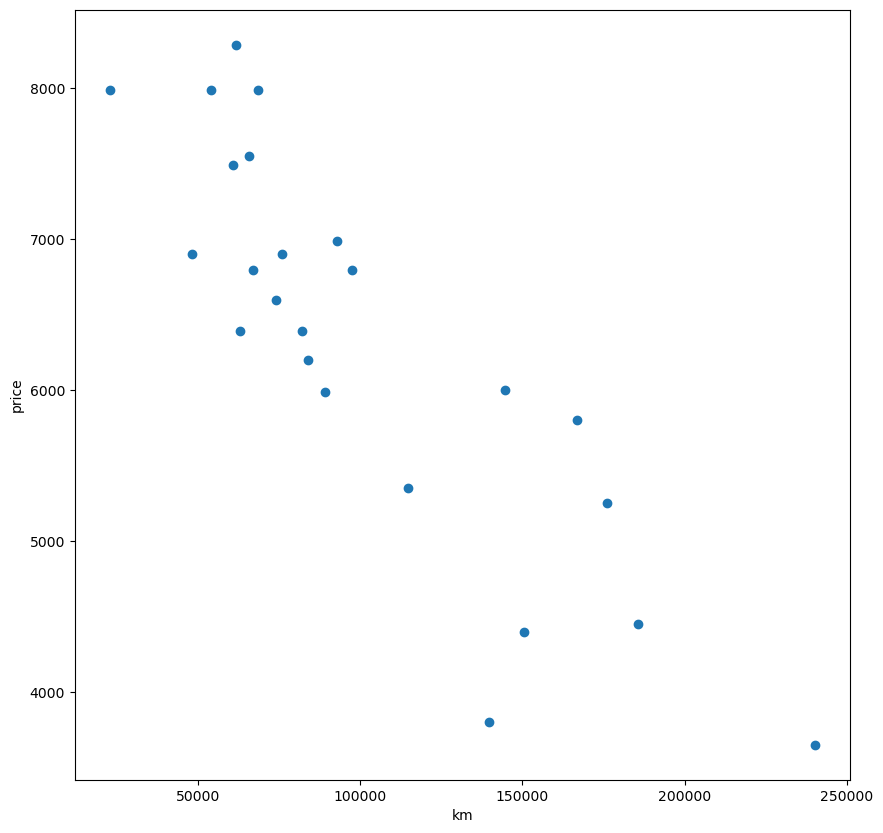

In [8]:
with open('../data.csv') as data_file:
    data_reader = csv.reader(data_file)
    raw_data = list(data_reader)
    # Slice to remove the first row (column names) and convert to integers
    data = np.array([[float(row[0]), float(row[1])] for row in raw_data[1:]])
    beta0, beta1 = fit_linear_with_mean_error_gradient_descent(data, 0.0, 0.0, 0.00001, 10000)
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel('km')
    plt.ylabel('price')
    plt.scatter(data[:, 0], data[:, 1])

There are several things that can go wrong if we do not properly scale our data. First, we can hit the precision limit of our underlying type if our datapoints are big numbers. Second, the comparative scaling between our dependent and independent variables can play a role during gradient descent if one is order of magnitude higher than the other one. Intuitively, this makes the cost landscape a narrow valley and the variable with bigger scaling is wrongly attributed more weight during gradient descent, causing oscillations around the valley.

This implies we need to preprocess our data in order to let the algorithm do its job without hitting the hardware limits. Two common ways of preprocessing the data are *normalization* and *standardization*. Normalization scales the data to a range between 0 and 1. Standardization scales the data so the mean is 0 and the standard deviation is 1 (also called the z-score).

More formally, normalization is defined as:

$$ x' = \frac{ x - x_{min} }{ x_{max} - x_{min} } $$

Standardization is defined as:

$$ x' = \frac{ x - \mu }{ \sigma } $$

where $\mu = \frac{1}{n}\sum_{i=1}^{n}x_i$ (the mean) et $\sigma = \sqrt{ \frac{ \sum_{i=1}^{n} \left( x_i - \mu \right) ^2 }{ n } }$ (the standard deviation)

Because these transformations are linear transformation, in theory once our model has converged, we can simply scale it back to use the original units.

In [9]:
from math import sqrt

def normalize(datapoints):
    x_min = min(datapoints[:,0])
    x_max = max(datapoints[:,0])
    y_min = min(datapoints[:,1])
    y_max = max(datapoints[:,1])
    normalized_datapoints = np.array([[(datapoint[0] - x_min) / (x_max - x_min), (datapoint[1] - y_min) / (y_max - y_min)] for datapoint in datapoints])
    return normalized_datapoints

def standardize(datapoints):
    mean_x = sum(datapoints[:,0]) / len(datapoints)
    mean_y = sum(datapoints[:,1]) / len(datapoints)
    sigma_x = sqrt(sum((datapoint[0] - mean_x) ** 2 for datapoint in datapoints) / len(datapoints))
    sigma_y = sqrt(sum((datapoint[1] - mean_y) ** 2 for datapoint in datapoints) / len(datapoints))
    standardized_datapoints = np.array([[(datapoint[0] - mean_x) / sigma_x, (datapoint[1] - mean_y) / sigma_y] for datapoint in datapoints])
    return standardized_datapoints

Let's use a scatter plot to see the result of normalization and standardization.

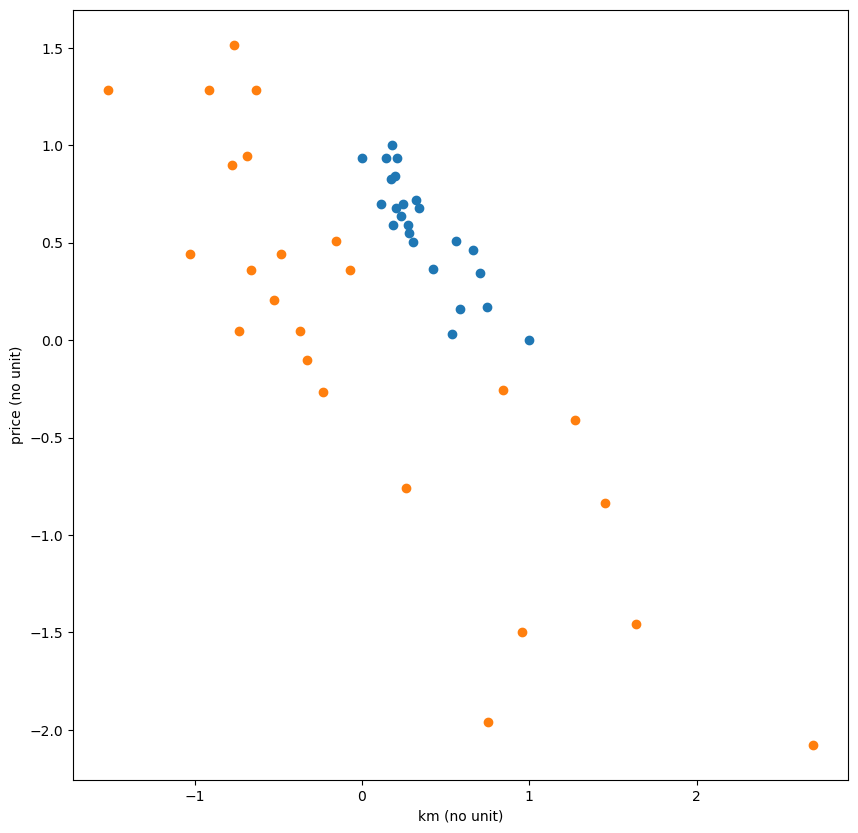

In [11]:
with open('../data.csv') as data_file:
    data_reader = csv.reader(data_file)
    raw_data = list(data_reader)
    # Slice to remove the first row (column names), convert to float and store in a numpy array
    data = np.array([[float(row[0]), float(row[1])] for row in raw_data[1:]])
    normalized_data = normalize(data)
    standardized_data = standardize(data)
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel('km (no unit)')
    plt.ylabel('price (no unit)')
    plt.scatter(normalized_data[:, 0], normalized_data[:, 1])
    plt.scatter(standardized_data[:, 0], standardized_data[:, 1])

Finally we can use our linear regression to fit the data.

Model: y = 2.6353919047042925e-16 + -0.8561394207904967x


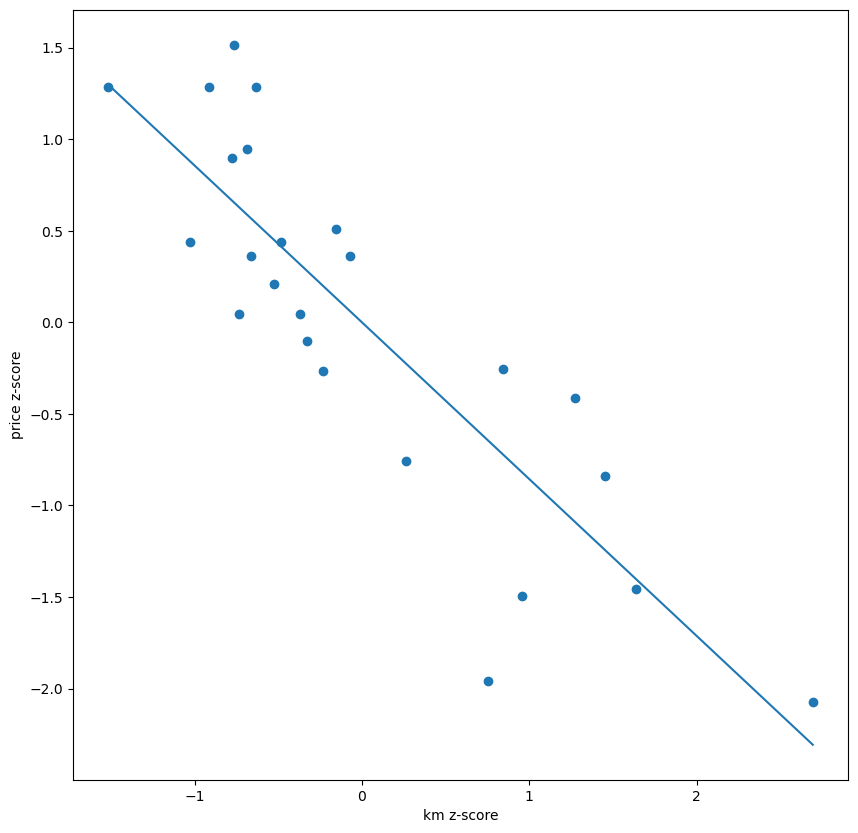

In [13]:
with open('../data.csv') as data_file:
    data_reader = csv.reader(data_file)
    raw_data = list(data_reader)
    # Slice to remove the first row (column names), convert to float and store in a numpy array
    data = np.array([[float(row[0]), float(row[1])] for row in raw_data[1:]])
    standardized_data = standardize(data)
    beta0, beta1 = fit_linear_with_mean_error_gradient_descent(standardized_data, 0, 0, 0.01, 5000)
    print(f'Model: y = {beta0} + {beta1}x')
    xs_model = np.linspace(min(standardized_data[:,0]), max(standardized_data[:,0]), 100)
    ys_model = np.array([linear_model(x, beta0, beta1) for x in xs_model])
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel('km z-score')
    plt.ylabel('price z-score')
    plt.plot(xs_model, ys_model)
    plt.scatter(standardized_data[:, 0], standardized_data[:, 1])
    plt.show()

Now that we can fit the data using their standardized form, we need a way to convert back our model to real units for prediction purposes. There are 2 possible methods: 1. we can use the standardized model and convert the result to real units or 2. we can directly convert the standardized coefficients to real units coefficients and use these in our linear model.

Using the first method, we can predict the dependent variable using the following formula (we denote the standardized coefficients $\beta^*_i$):

$$y = \sigma_y \beta^*_0 + \sigma_y \beta^*_1 \dfrac{x - \mu_x}{\sigma_x} + \mu_y$$

Using the second solution, we have:

$$\beta_0 = \beta^*_0 \sigma_y + \mu_y = \beta^*_1 \dfrac{\sigma_y}{\sigma_x} \mu_x$$

$$\beta_1 = \beta^*_1 \dfrac{\sigma_y}{\sigma_x}$$

Model: y = 2.6353919047042925e-16 + -0.8561394207904967x


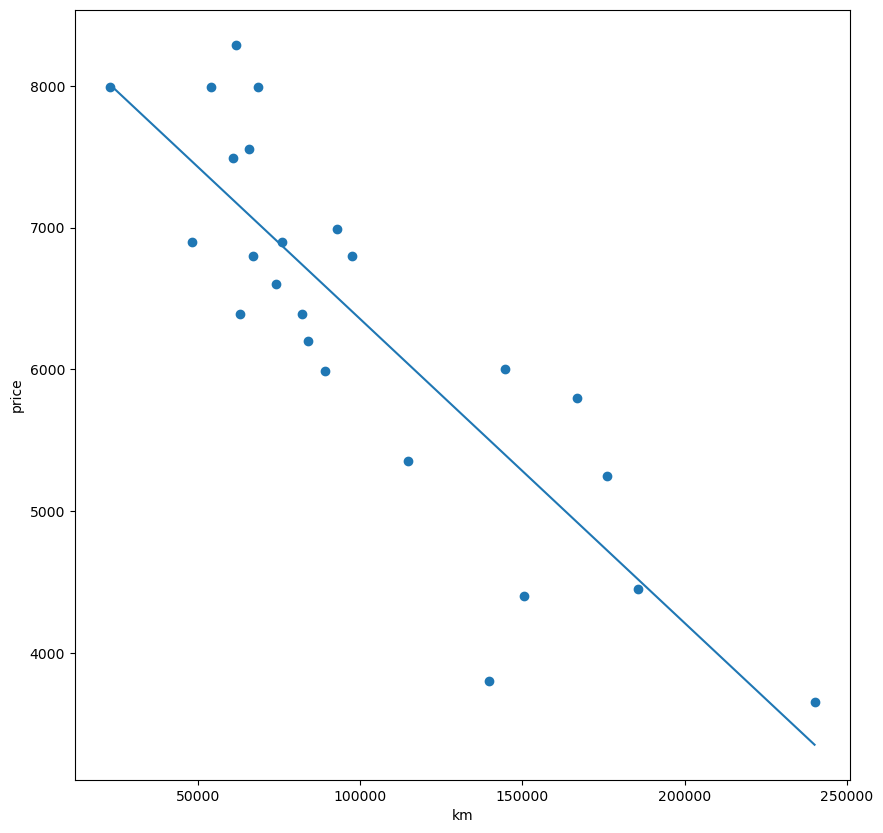

In [15]:
# Solution 1: predict with the standardized model and convert back to real units
with open('../data.csv') as data_file:
    data_reader = csv.reader(data_file)
    raw_data = list(data_reader)
    # Slice to remove the first row (column names), convert to float and store in a numpy array
    data = np.array([[float(row[0]), float(row[1])] for row in raw_data[1:]])
    mean_x = sum(data[:,0]) / len(data)
    mean_y = sum(data[:,1]) / len(data)
    sigma_x = sqrt(sum((datapoint[0] - mean_x) ** 2 for datapoint in data) / len(data))
    sigma_y = sqrt(sum((datapoint[1] - mean_y) ** 2 for datapoint in data) / len(data))
    standardized_data = standardize(data)
    standardized_beta0, standardized_beta1 = fit_linear_with_mean_error_gradient_descent(standardized_data, 0, 0, 0.01, 5000)
    print(f'Model: y = {beta0} + {beta1}x')
    xs_model = np.linspace(min(data[:,0]), max(data[:,0]), 100)
    # Here we scale back to the real units directly
    ys_model = np.array([sigma_y * standardized_beta0 + sigma_y * standardized_beta1 * ((x - mean_x) / sigma_x) + mean_y for x in xs_model])
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel('km')
    plt.ylabel('price')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(xs_model, ys_model)
    plt.show()

Model: y = 8499.599649933201 + -0.021448963591702164x


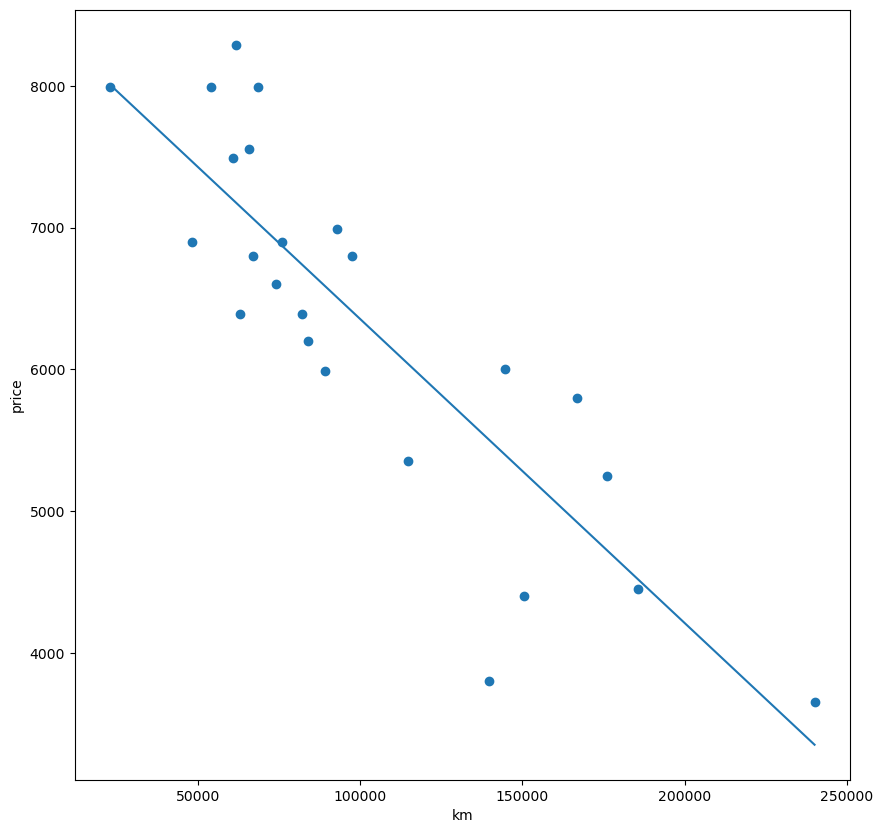

In [17]:
# Solution 2: Convert the standardized coefficients to unit coefficients and use these to predict
with open('../data.csv') as data_file:
    data_reader = csv.reader(data_file)
    raw_data = list(data_reader)
    # Slice to remove the first row (column names), convert to float and store in a numpy array
    data = np.array([[float(row[0]), float(row[1])] for row in raw_data[1:]])
    mean_x = sum(data[:,0]) / len(data)
    mean_y = sum(data[:,1]) / len(data)
    sigma_x = sqrt(sum((datapoint[0] - mean_x) ** 2 for datapoint in data) / len(data))
    sigma_y = sqrt(sum((datapoint[1] - mean_y) ** 2 for datapoint in data) / len(data))
    standardized_data = standardize(data)
    standardized_beta0, standardized_beta1 = fit_linear_with_mean_error_gradient_descent(standardized_data, 0, 0, 0.01, 5000)
    # Here we convert back the standard coefficients to the unstandardized coefficients
    beta0 = standardized_beta0 * sigma_y + mean_y - standardized_beta1 * (sigma_y / sigma_x) * mean_x
    beta1 = standardized_beta1 * (sigma_y / sigma_x)
    print(f'Model: y = {beta0} + {beta1}x')
    xs_model = np.linspace(min(data[:,0]), max(data[:,0]), 100)
    ys_model = np.array([linear_model(x, beta0, beta1) for x in xs_model])
    plt.rcParams["figure.figsize"] = (10, 10)
    plt.xlabel('km')
    plt.ylabel('price')
    plt.scatter(data[:, 0], data[:, 1])
    plt.plot(xs_model, ys_model)
    plt.show()

Concepts:
- The model: the function through which we are trying to model the datapoints (e.g. linear model, logistic model, ...)
- The error function: the function that evaluates the error of the model compared to the dataset (e.g. mean error, mean squared error, ...)
- The optimization scheme: the algorithm through which we try to minimize the error by descending the gradient of the error function (e.g. batch gradient descent, stochastic gradient descent, ...)